# Regression of Used Car Prices

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import category_encoders as ce
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

import shap


In [ ]:
data = pd.read_csv('train.csv')
data.head()


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


Рассмотрим столбцы:
1. id - совпадает с индексом нашей строки
2. brand - марка автомобиля
3. model - модель автомобиля
4. model_year - год выпуска
5. milage - пробег
6. fuel_type - тип топлива
7. engine - двигатель(мощность + объём + кол-во цилиндров + тип двигателя + тип топлива)
8. transmission - тип коробки передач
9. ext_col - цвет автомобиля
10. int_col - цвет салона
11. accident - информация о ДТП
12. clean_title - статус юридической чистоты автомобиля 
13. price - цена автомобиля

# Exploratiry Data Analysis

In [ ]:
# Удалим столбец id
data = data.drop(columns = ['id'])
data.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [ ]:
# Создадим список категориальных фичей
categorical_columns = data.select_dtypes(include=['object']).columns.to_list()
# Создадим список числовых фичей
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.difference(['price','id']).to_list()
# Создадим target с ценами автомобилей
target = 'price'

print("Categorical_columns:")
print(categorical_columns)
print("Numerical_columns:")
print(numerical_columns)

print()

Categorical_columns:
['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Numerical_columns:
['milage', 'model_year']



# Data processing

In [ ]:
# Посмотрим,сколько пропусков у нас в каждом признаке и какой процент от всех данных составляют пропуски
total_rows = len(data)
missing_counts = data.isnull().sum()
missing_percentage = (missing_counts / total_rows) * 100

missing_data = pd.DataFrame({
    'Feature': missing_counts.index,  # Название признаков
    'Missing Count': missing_counts.values,  # Количество пропусков
    'Missing Percentage': missing_percentage.values  # Процент пропусков
})

# Сортировка по убыванию количества пропусков
missing_data = missing_data.sort_values(by=['Missing Count', 'Missing Percentage'], ascending=False)
print(missing_data)

         Feature  Missing Count  Missing Percentage
10   clean_title          21419           11.360876
4      fuel_type           5083            2.696080
9       accident           2452            1.300568
0          brand              0            0.000000
1          model              0            0.000000
2     model_year              0            0.000000
3         milage              0            0.000000
5         engine              0            0.000000
6   transmission              0            0.000000
7        ext_col              0            0.000000
8        int_col              0            0.000000
11         price              0            0.000000


У нас пропуски в столбцах: clean_title(11%),fuel_type(2.7%) и accident(1.3%):
1. Пропуски в clean_title логичнее всего заполнить NO - то есть у автомобиля нет юридической чистоты,раз это не указано.
2. Пропущенные значения в fuel_type можем достать из столбца engine.
3. Пропуски в accident можно заполнить At least 1 accident or damage reported,раз не указано None reported,значит скорее всего были ДТП.

In [ ]:
data['accident'] = data['accident'].fillna('At least 1 accident or damage reported')
data['clean_title'] = data['clean_title'].fillna('NO')

In [ ]:
fuel_type_counts = data['fuel_type'].sort_values()

Количество различных видов топлива до заполнения пропусков 7
fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64


In [ ]:
# Создадим функцию,которая в описании двигателя находит тип топлива
def findFuel(engine):
    mas = engine.split()
    for type in list(fuel_type_counts.index):
        if type in mas:
            return type
    return "unknown"

In [ ]:
data['fuel_type'] = data.apply(
    lambda row: findFuel(row['engine']) if pd.isna(row['fuel_type']) else row['fuel_type'], axis=1
)

In [ ]:
# Проверим,что заполнили все пропущенные значения
missing_counts = data.isna().sum().sum()
print(missing_counts)

0


Заполнили все пропуски в датасете.

In [ ]:
# Масштабируем числовые признаки
scaler = StandardScaler()
scaler.fit_transform(data[numerical_columns])

array([[ 2.95784224, -1.55980788],
       [ 1.55718431, -2.4430515 ],
       [ 1.42627551, -2.4430515 ],
       ...,
       [-1.04532849,  0.91327427],
       [-1.04040861,  1.089923  ],
       [-0.12460926,  0.03003065]])

In [ ]:
# Преобразуем тип категориальных признаков в category
for feature in categorical_columns:
    data[feature] = data[feature].astype('category')

In [ ]:
# Разделим наши данные на тренировочную и тестовую выборку
X = data.drop('price',axis = 1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [ ]:
# Целевая кодировка категориальных признаков
target_encoder = ce.TargetEncoder(cols=categorical_columns)

In [ ]:
# Обучаем кодировщик на тренировочных данных и применяем его
X_train_encoded = target_encoder.fit_transform(X_train, y_train)
X_test_encoded = target_encoder.transform(X_test)

# LGBM

In [ ]:
# Обучение модели LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)
lgb_model.fit(X_train_encoded,
                y_train,
                eval_set=[(X_test_encoded, y_test)],
                callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(10)])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1254
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 11
[LightGBM] [Info] Start training from score 43890.785316
Training until validation scores don't improve for 50 rounds
[10]	valid_0's l2: 4.98689e+09
[20]	valid_0's l2: 4.77785e+09
[30]	valid_0's l2: 4.70088e+09
[40]	valid_0's l2: 4.67339e+09
[50]	valid_0's l2: 4.66579e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's l2: 4.66463e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=1000,
              random_state=42)

In [ ]:
# Предсказания для LightGBM
lgb_predictions = lgb_model.predict(X_test_encoded)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_predictions))
print(f'RMSE для LightGBM: {lgb_rmse}')

RMSE для LightGBM: 68288.27007791356


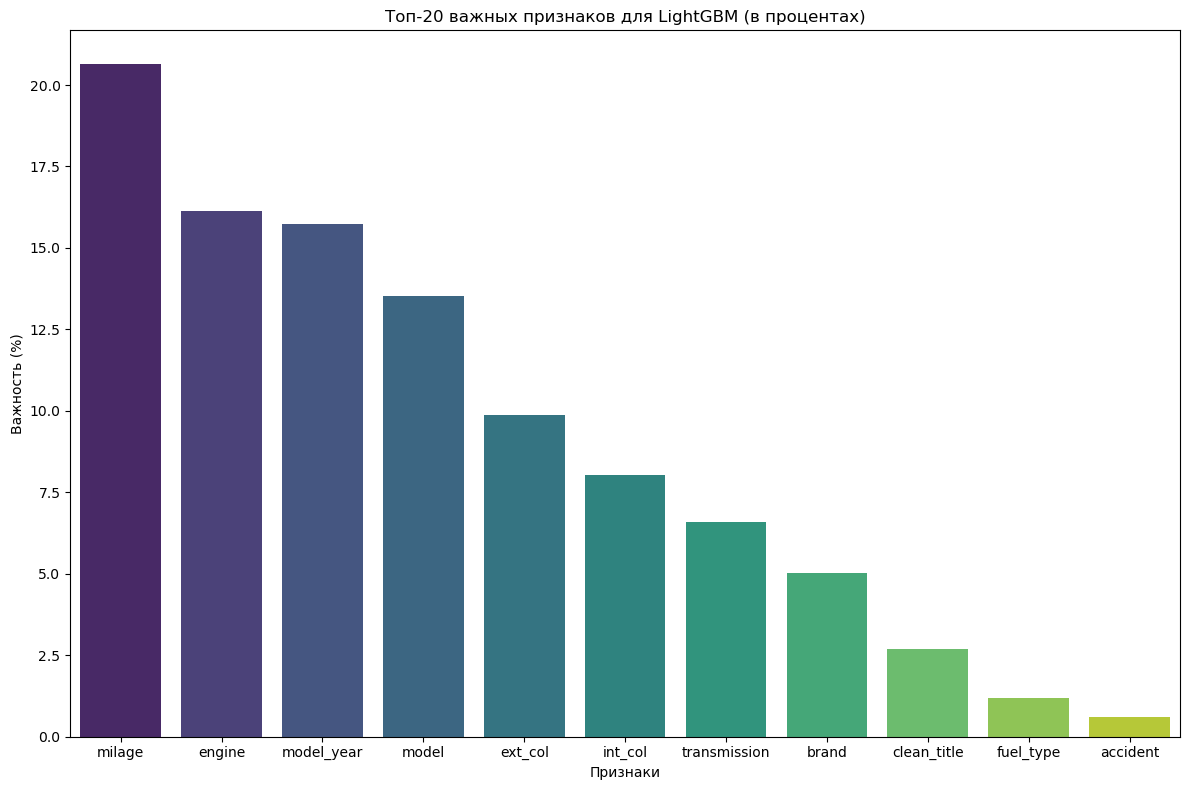

In [ ]:
# Получение важности признаков
feature_importances = lgb_model.feature_importances_
feature_names = X_train_encoded.columns

# Создание DataFrame с важностями признаков
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importances
})

# Вычисление процентной важности
importance_df['Важность (%)'] = 100 * (importance_df['Важность'] / importance_df['Важность'].sum())

# Сортировка признаков по убыванию процентной важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# Отображение важности признаков в процентах
plt.figure(figsize=(12, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')


plt.title("Топ-20 важных признаков для LightGBM (в процентах)")
plt.xlabel("Признаки")
plt.ylabel("Важность (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# XGBoost

In [ ]:
print(xgb.__version__)

2.1.1


In [ ]:
# Инициализация модели
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    random_state=42,
    early_stopping_rounds=100
)

# Обучение модели с ранней остановкой
xgb_model.fit(
    X_train_encoded, y_train,
    eval_set=[(X_test_encoded, y_test)],
    # early_stopping_rounds=100,  # Используем правильный параметр
    verbose=True
)

[0]	validation_0-rmse:73978.40083
[1]	validation_0-rmse:73445.06674
[2]	validation_0-rmse:72955.40026
[3]	validation_0-rmse:72519.43637
[4]	validation_0-rmse:72141.50363
[5]	validation_0-rmse:71795.76866
[6]	validation_0-rmse:71510.69849
[7]	validation_0-rmse:71250.81474
[8]	validation_0-rmse:71029.41507
[9]	validation_0-rmse:70803.09946
[10]	validation_0-rmse:70626.22519
[11]	validation_0-rmse:70474.52885
[12]	validation_0-rmse:70305.81524
[13]	validation_0-rmse:70178.64885
[14]	validation_0-rmse:70047.48372
[15]	validation_0-rmse:69932.85161
[16]	validation_0-rmse:69838.35774
[17]	validation_0-rmse:69752.06259
[18]	validation_0-rmse:69670.81287
[19]	validation_0-rmse:69609.67770
[20]	validation_0-rmse:69562.12001
[21]	validation_0-rmse:69540.04348
[22]	validation_0-rmse:69509.00755
[23]	validation_0-rmse:69486.16934
[24]	validation_0-rmse:69495.41627
[25]	validation_0-rmse:69496.47696
[26]	validation_0-rmse:69498.72046
[27]	validation_0-rmse:69461.59169
[28]	validation_0-rmse:69472.8

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Предсказания для XGBoost
xgb_predictions = xgb_model.predict(X_test_encoded)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
print(f'RMSE для XGBoost: {xgb_rmse}')

RMSE для XGBoost: 69461.59182725479


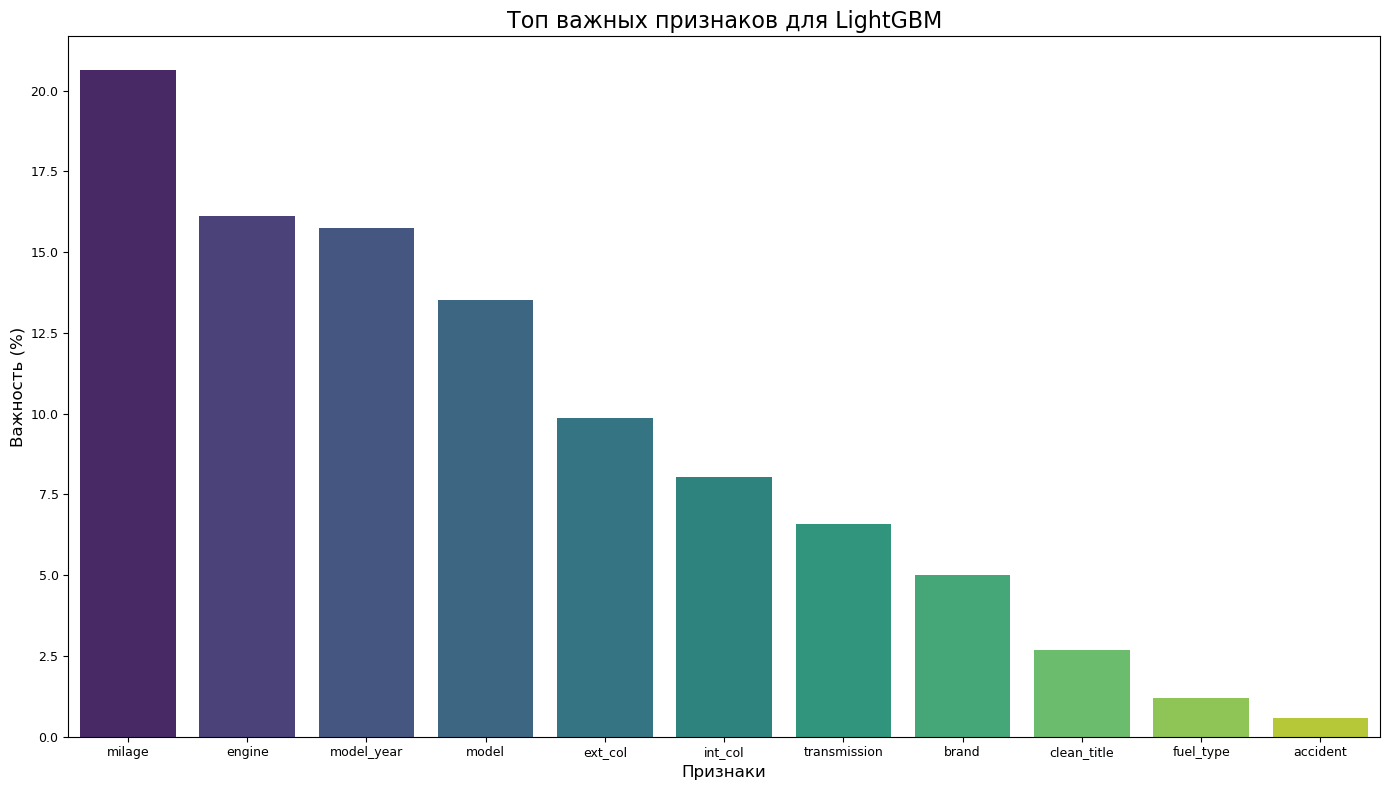

In [ ]:
# Получение важности признаков
feature_importances = lgb_model.feature_importances_
feature_names = X_train_encoded.columns

# Создание DataFrame с важностями признаков
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importances
})

# Вычисление процентной важности
importance_df['Важность (%)'] = 100 * (importance_df['Важность'] / importance_df['Важность'].sum())

# Сортировка признаков по убыванию процентной важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# Отображение важности признаков в процентах с вертикальными столбцами
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')


plt.title("Топ важных признаков для LightGBM", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

# Linear Regression

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train_encoded, y_train)

LinearRegression()

In [ ]:
# Предсказания для XGBoost
lr_predictions = lr_model.predict(X_test_encoded)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
print(f'RMSE для LinearRegression: {lr_rmse}')

RMSE для LinearRegression: 68776.21600001412


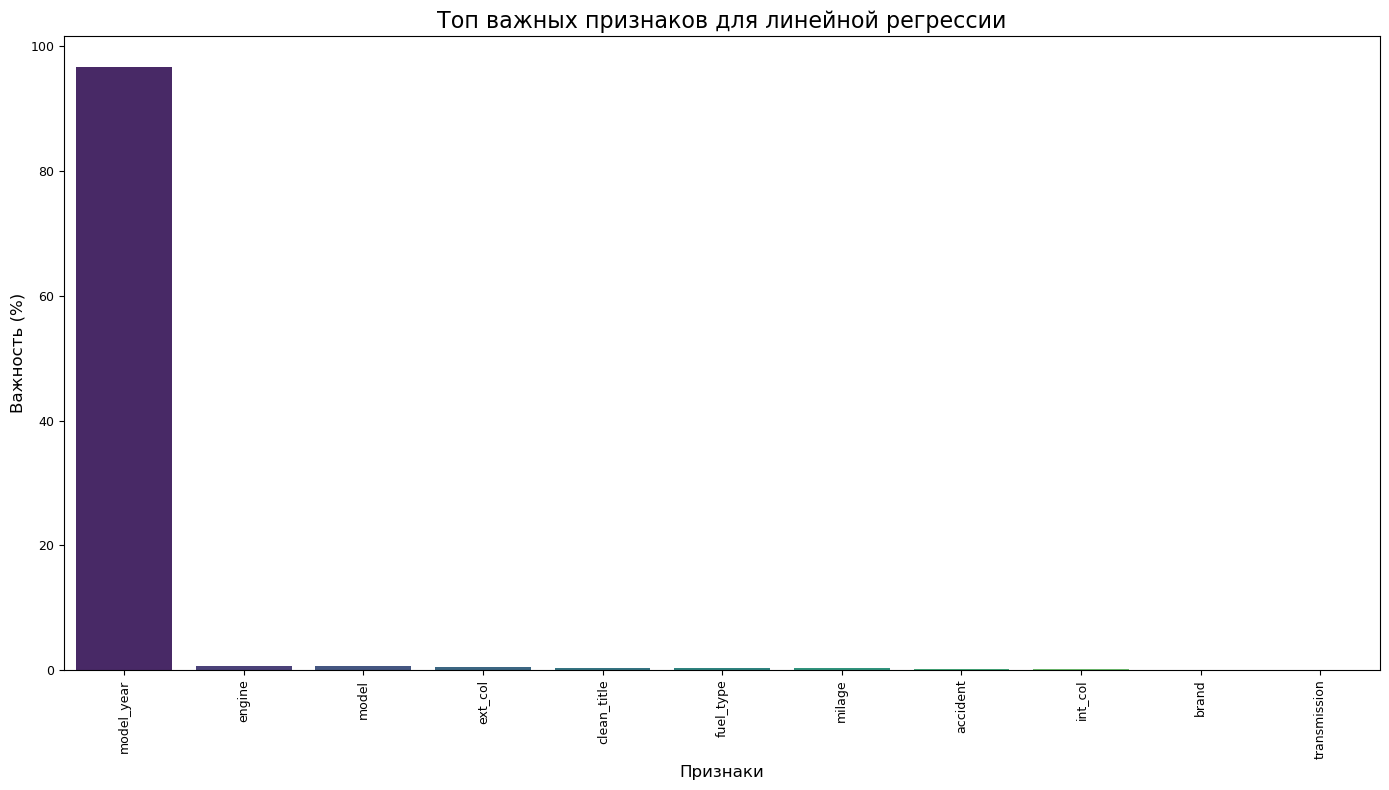

In [ ]:
# 3. Получение коэффициентов модели
coefficients = lr_model.coef_

# 4. Вычисление абсолютных значений коэффициентов для важности
importance = np.abs(coefficients)

# 5. Преобразование важности в проценты
importance_percentage = 100 * (importance / importance.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# 6. Построение вертикального столбчатого графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')

plt.title("Топ важных признаков для линейной регрессии", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

# Ridge

In [ ]:
ridge_model = Ridge()
ridge_model.fit(X_train_encoded, y_train)

Ridge()

In [ ]:
# Предсказания для XGBoost
ridge_predictions = ridge_model.predict(X_test_encoded)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_predictions))
print(f'RMSE для Ridge: {ridge_rmse}')

RMSE для Ridge: 68776.21599841789


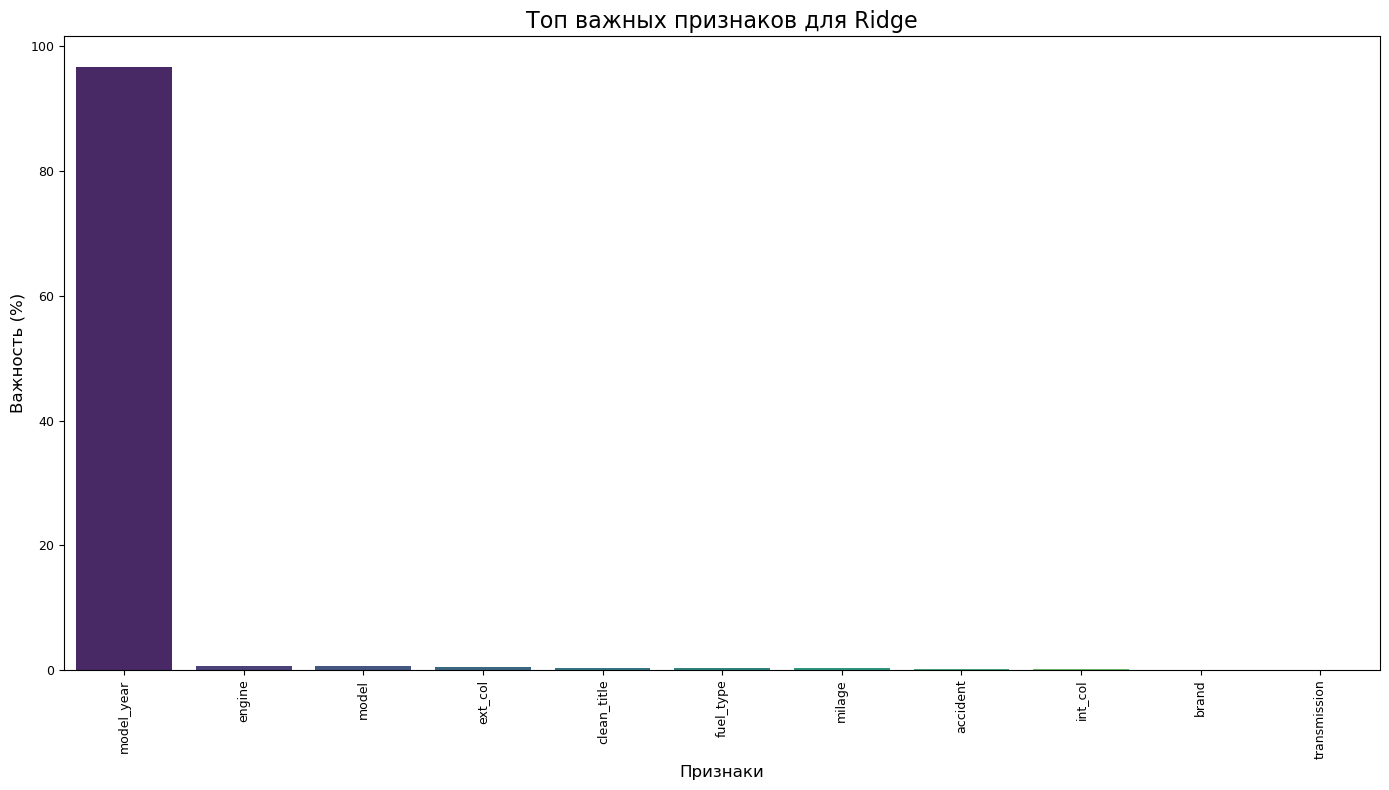

In [ ]:
# 3. Получение коэффициентов модели
coefficients = ridge_model.coef_

# 4. Вычисление абсолютных значений коэффициентов для важности
importance = np.abs(coefficients)

# 5. Преобразование важности в проценты
importance_percentage = 100 * (importance / importance.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# 6. Построение вертикального столбчатого графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')

plt.title("Топ важных признаков для Ridge", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

# RandomForest

In [ ]:

rf_model = RandomForestRegressor(
    n_estimators=100,          # Количество деревьев в лесу
    max_depth=None,            # Максимальная глубина дерева
    random_state=42,           # Для воспроизводимости результатов
    n_jobs=-1                  # Использовать все доступные ядра процессора
)
rf_model.fit(X_train_encoded, y_train)

In [ ]:
# Предсказания для RandomForestRegressor
rf_predictions = rf_model.predict(X_test_encoded)

# Оценка модели с использованием RMSE
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f'RMSE для RandomForestRegressor: {rf_rmse}')

In [ ]:
# Получение важности признаков
feature_importances = rf_model.feature_importances_

# Преобразование важности в проценты
importance_percentage = 100 * (feature_importances / feature_importances.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X_train_encoded.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# Построение вертикального столбчатого графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')

# Добавление процентных значений над столбиками
for index, row in importance_df.iterrows():
    plt.text(
        x=index,
        y=row['Важность (%)'] + 0.5,  # Немного выше вершины столбика
        s=f"{row['Важность (%)']:.1f}%",
        ha='center',
        fontsize=9
    )

plt.title("Топ-20 важных признаков для RandomForestRegressor", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()